In [1]:
import pandas as pd
import os
import cv2
import argparse
from typing import Tuple
import albumentations as A
import pandas as pd
import torch
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn, optim
from torchvision import datasets, transforms, models
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from torch.nn import functional as F
from PIL import Image


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def plot_samples(df, data_root_path, category, num_imgs=20, num_cols=5):
    
    paths = df[df.category == category].file_path.sample(num_imgs)
    
    num_rows = num_imgs // num_cols 
    if num_imgs % num_cols != 0:
        num_rows += 1
    
    fig = plt.figure(figsize=(num_cols * 4, num_rows * 4))
    for idx, path in enumerate(paths):

        ax = fig.add_subplot(num_rows,num_cols,idx+1)
        
        im = cv2.imread(os.path.join(data_root_path, path))
        im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)

        plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.tight_layout()
        
    plt.show()
# for category in sorted(train_df.category.unique()):
#     print(category)
#     plot_samples(train_df, TRAIN_PATH, category, 5, 5)

In [3]:
# Define data augmentation transforms
train_transforms = A.Compose([
    A.Resize(224, 224),  # Resize images to a specific size
    A.HorizontalFlip(p=0.5),  # Randomly flip the image horizontally with a 50% probability
    A.RandomRotate90(p=0.5),  # Randomly rotate the image by 90 degrees with a 50% probability
    A.RandomBrightnessContrast(p=0.2),  # Randomly adjust brightness and contrast with a 20% probability
    A.Normalize(),  # Normalize pixel values
    ToTensorV2(),  # Convert the image to a PyTorch tensor
])

test_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2(),
])

In [4]:
class ResNetBase(nn.Module):
    def __init__(self, backbone='resnext50_32x4d_ssl'):
        super(ResNetBase, self).__init__()
        if backbone.endswith('l'):
            self.backbone = torch.hub.load(
                'facebookresearch/semi-supervised-ImageNet1K-models',
                backbone,
            )
        else:
            self.backbone = getattr(models, backbone)(pretrained=True)
        self.out_features = self.backbone.fc.in_features

    def forward(self, x):
        base = self.backbone
        x = base.conv1(x)
        x = base.bn1(x)
        x = base.relu(x)
        x = base.maxpool(x)

        x = base.layer1(x)
        x = base.layer2(x)
        x = base.layer3(x)
        x = base.layer4(x)
        return x

In [5]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [6]:
early_stopping = EarlyStopping(patience=10, verbose=True)

In [7]:
class ResNetHead(nn.Module):
    def __init__(self, in_features: int, n_classes: int, use_neck: bool):
        super().__init__()

        self.pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(in_features, n_classes)
        self.use_neck = use_neck

    def forward(self, x):
        if not self.use_neck:
            x = self.pooling(x)
            x = torch.flatten(x, start_dim=1)
        x = self.apply_fc_out(x)
        return x

    def apply_fc_out(self, x):
        return self.fc1(x)


In [8]:
class Neck(nn.Module):
    def __init__(self, in_features: int, hidden_dim):
        super().__init__()

        self.pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.bn1 = nn.BatchNorm1d(in_features)
        self.fc1 = nn.Linear(in_features, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)

    def forward(self, x):

        x = self.pooling(x)
        x = torch.flatten(x, start_dim=1)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = self.bn2(x)
        x = self.fc2(x)
        x = self.bn3(x)

        return x

In [9]:
#build resnext model

def build_model(backbone: str, n_classes: int, **kwargs) -> nn.Module:
    return Model(backbone=backbone, n_classes=n_classes, **kwargs)


class Model(nn.Module):
    def __init__(self, *, backbone: str, n_classes: int, use_neck: bool,):
        super().__init__()

        self.backbone = ResNetBase(backbone)
        self.in_features = self.backbone.out_features
        self.use_neck = use_neck
        if self.use_neck:
            self.hidden_dim = 1024
            self.neck = Neck(self.in_features, 1024)
            self.in_features = self.hidden_dim
        self.head = ResNetHead(self.in_features, n_classes, self.use_neck)

    def forward(self, x):
        x = self.backbone(x)
        if self.use_neck:
            x = self.neck(x)
        x = self.head(x)
        return x
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

***ResNext folder Image Testing***

Downloading: "https://github.com/facebookresearch/semi-supervised-ImageNet1K-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_supervised_resnext50_32x4-ddb3e555.pth" to /root/.cache/torch/hub/checkpoints/semi_supervised_resnext50_32x4-ddb3e555.pth
100%|██████████| 95.8M/95.8M [00:01<00:00, 67.1MB/s]


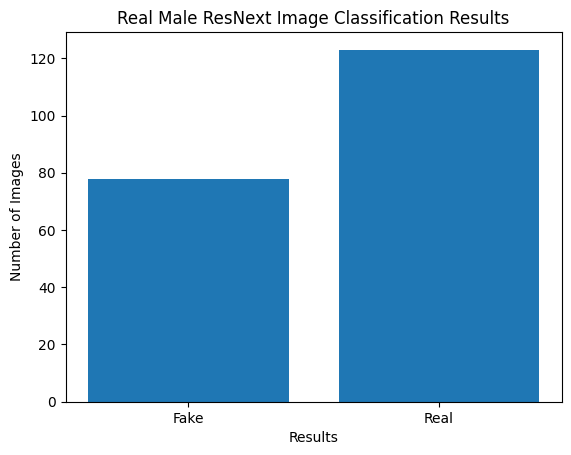

In [10]:
import torch
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt

# Define the path to the saved checkpoint
checkpoint_path = "/kaggle/input/datrgfff/model_8.pth"  # Update with the correct path

# Load the pre-trained model architecture (same as the one used for training)
model = build_model(
    backbone='resnext50_32x4d_ssl',
    n_classes=2,  # Update with the correct number of classes
    use_neck=0,
)

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set the model to evaluation mode

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Update with the correct values
])

# Define the folder containing images
image_folder = "/kaggle/input/real-dataset-for-deepfake-test/deepfake real dataset/male"

# Create a list to store the results
results = []

# Iterate through the images in the folder
for filename in os.listdir(image_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # You can specify the file extensions you want to process
        image_path = os.path.join(image_folder, filename)
        image = Image.open(image_path)
        image = transform(image)
        image = image.unsqueeze(0)  # Add a batch dimension

        # Make predictions
        with torch.no_grad():
            output = model(image)

        # Post-process the predictions
        predicted_class = output.argmax(dim=1).item()  # Get the class with the highest probability

        # Define the mapping
        class_mapping = {
            0: "fake",
            1: "real"
        }

        # Get the corresponding label
        predicted_label = class_mapping.get(predicted_class, "unknown")

        # Store the result for this image
        results.append({"image_path": image_path, "predicted_label": predicted_label})

# Count the number of fake and real images
fake_count = sum(1 for result in results if result["predicted_label"] == "fake")
real_count = sum(1 for result in results if result["predicted_label"] == "real")

# Create a bar chart
labels = ["Fake", "Real"]
counts = [fake_count, real_count]

plt.bar(labels, counts)
plt.xlabel("Results")
plt.ylabel("Number of Images")
plt.title("Real Male ResNext Image Classification Results")
plt.show()


***ResNext Single Image Testing***

In [11]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the saved checkpoint
checkpoint_path = "/kaggle/input/datrgfff/model_8.pth"

# Load the pre-trained model architecture (make sure to define build_model function)
model = build_model(
    backbone='resnext50_32x4d_ssl',
    n_classes=2,  # Update with the correct number of classes
    use_neck=0,
)

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set the model to evaluation mode

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Update with the correct values
])

# Define the path to the single image you want to test
image_path = "/kaggle/input/thispersondoesnotexist/thispersondoesnotexist/person_10.png"

# Load the single image
image = Image.open(image_path)
image = transform(image)
image = image.unsqueeze(0)  # Add a batch dimension

# Make predictions
with torch.no_grad():
    output = model(image)

# Post-process the predictions
predicted_class = output.argmax(dim=1).item()  # Get the class with the highest probability

# Define the mapping
class_mapping = {
    0: "fake",
    1: "real"
}

# Get the corresponding label
predicted_label = class_mapping.get(predicted_class, "unknown")

# Print the predicted label for the single image
print("Predicted Label:", predicted_label)


Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


Predicted Label: real


***VGG FOLDER IMAGE TEST***

1/1 [==============================] - 0s 24ms/step


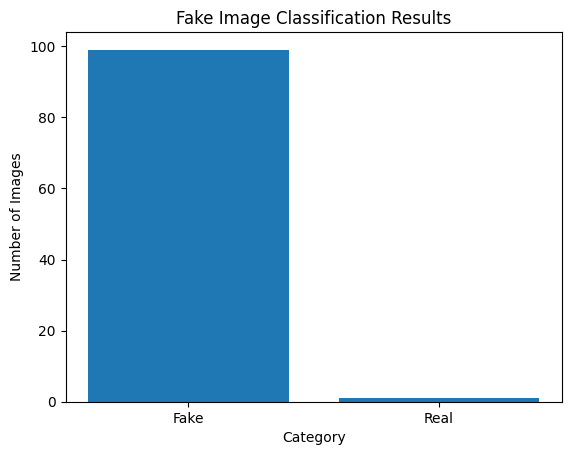

In [12]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load your pre-trained .h5 model
model = load_model("/kaggle/input/datrgfff/vgg.h5")  # Update with the correct path

# Define the image dimensions that your model expects (e.g., 256x256)
image_height, image_width = 256, 256  # Update with the correct dimensions

# Define the folder containing images to predict
image_folder = "/kaggle/input/thispersondoesnotexist/thispersondoesnotexist"  # Update with the correct path

# Create a list to store the results
results = []

# Iterate through the images in the folder
for filename in os.listdir(image_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(image_folder, filename)

        # Load and preprocess the image
        image = cv2.imread(image_path)
        image = cv2.resize(image, (image_width, image_height))
        image = np.expand_dims(image, axis=0)  # Add a batch dimension
        image = image / 255.0  # Normalize the image (if your model requires it)

        # Make predictions
        prediction = model.predict(image)

        # Assuming your model is binary classification, you can change this logic
        # Compare the probability to a threshold (e.g., 0.5) to determine the predicted class
        predicted_class = 1 if prediction[0, 0] > 0.5 else 0

        results.append(predicted_class)

# Count the number of "Fake" and "Real" predictions
fake_count = sum(1 for result in results if result == 0)
real_count = sum(1 for result in results if result == 1)

# Create a bar chart
labels = ["Fake", "Real"]
counts = [fake_count, real_count]

plt.bar(labels, counts)
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.title("Fake Image Classification Results")
plt.show()


***VGG SINGLE IMAGE TESTING***

1/1 [==============================] - 0s 204ms/step


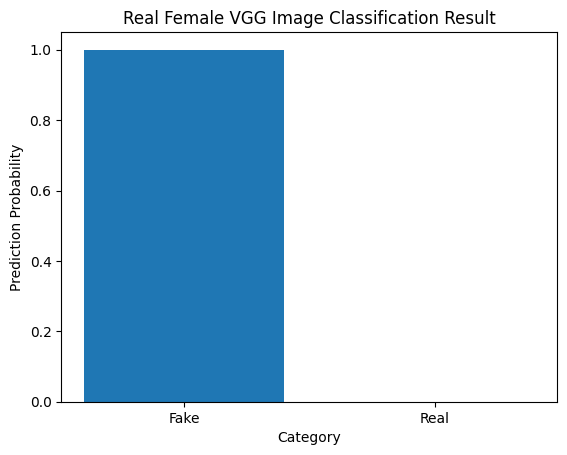

In [13]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load your pre-trained .h5 model
model = load_model("/kaggle/input/datrgfff/vgg.h5")  # Update with the correct path

# Define the image dimensions that your model expects (e.g., 256x256)
image_height, image_width = 256, 256  # Update with the correct dimensions

# Define the path to the single image you want to predict
image_path = "/kaggle/input/real-dataset-for-deepfake-test/deepfake real dataset/female/Copy of DBCL-DBIT-IT-112.JPGface4.jpg"  # Update with the correct path

# Load and preprocess the image
image = cv2.imread(image_path)
image = cv2.resize(image, (image_width, image_height))
image = np.expand_dims(image, axis=0)  # Add a batch dimension
image = image / 255.0  # Normalize the image (if your model requires it)

# Make predictions
prediction = model.predict(image)

# Assuming your model is binary classification, you can change this logic
# Compare the probability to a threshold (e.g., 0.5) to determine the predicted class
predicted_class = 1 if prediction[0, 0] > 0.5 else 0

# Create a bar chart to visualize the result
labels = ["Fake", "Real"]
counts = [1 - predicted_class, predicted_class]  # 0 for Fake, 1 for Real

plt.bar(labels, counts)
plt.xlabel("Category")
plt.ylabel("Prediction Probability")
plt.title("Real Female VGG Image Classification Result")
plt.show()


***EFFICIENT NET B2 FOLDER IMAGE TESTING***

1/1 [==============================] - 0s 28ms/step


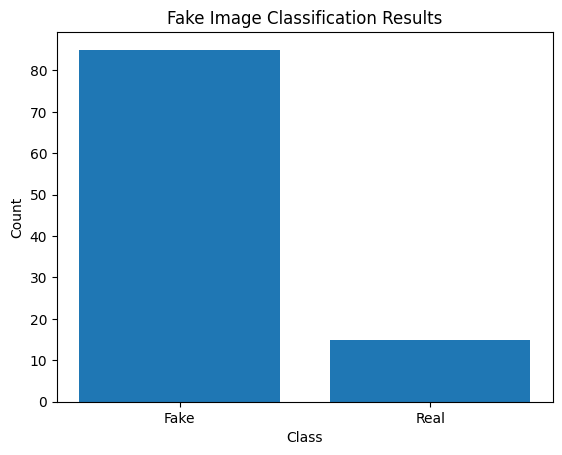

In [14]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt

# Load your pre-trained .h5 model
model = load_model("/kaggle/input/datrgfff/efficientNet-om.h5")  # Update with the correct path

# Define the image dimensions that your model expects
model_image_height, model_image_width = 256, 256  # Model's input dimensions
image_folder = "/kaggle/input/thispersondoesnotexist/thispersondoesnotexist"  # Update with the correct path

# Create a list to store the results
results = []

# Iterate through the images in the folder
for filename in os.listdir(image_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(image_folder, filename)

        # Load the image
        image = cv2.imread(image_path)

        # Resize the image to match the model's input size
        image = cv2.resize(image, (model_image_width, model_image_height))

        # Preprocess the image according to EfficientNet requirements
        image = np.expand_dims(image, axis=0)  # Add a batch dimension
        image = preprocess_input(image)

        # Make predictions
        prediction = model.predict(image)

        # Assuming your model is binary classification
        # The first class (0) represents "Fake," and the second class (1) represents "Real"
        predicted_class = "Fake" if prediction[0, 0] > 0.5 else "Real"

        results.append(predicted_class)

# Create a bar chart showing the predicted classes
unique, counts = np.unique(results, return_counts=True)

plt.bar(unique, counts)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Fake Image Classification Results")
plt.show()


***EFFICIENT NET B2 SINGLE IMAGE TESTING***

1/1 [==============================] - 2s 2s/step


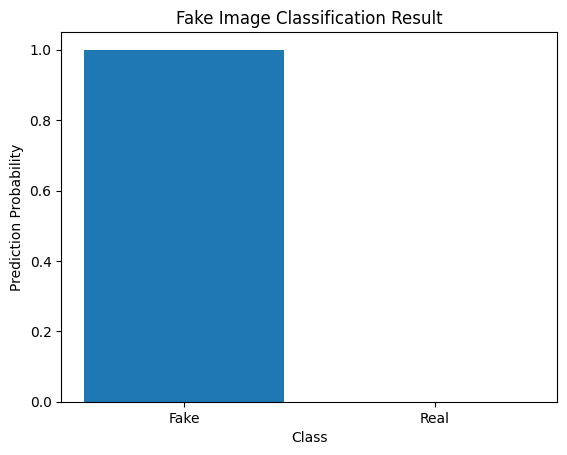

In [15]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt

# Load your pre-trained .h5 model
model = load_model("/kaggle/input/datrgfff/efficientNet-om.h5")  # Update with the correct path

# Define the image dimensions that your model expects
model_image_height, model_image_width = 256, 256  # Model's input dimensions

# Define the path to the single image you want to predict
image_path = "/kaggle/input/real-dataset-for-deepfake-test/deepfake real dataset/male/Copy of DBCL-DBIT-IT-102.JPGface1.jpg"  # Update with the correct path

# Load the image
image = cv2.imread(image_path)

# Resize the image to match the model's input size
image = cv2.resize(image, (model_image_width, model_image_height))

# Preprocess the image according to EfficientNet requirements
image = np.expand_dims(image, axis=0)  # Add a batch dimension
image = preprocess_input(image)

# Make predictions
prediction = model.predict(image)

# Assuming your model is binary classification
# The first class (0) represents "Fake," and the second class (1) represents "Real"
predicted_class = "Fake" if prediction[0, 0] > 0.5 else "Real"

# Create a bar chart to visualize the result for the single image
labels = ["Fake", "Real"]
counts = [1 if predicted_class == "Fake" else 0, 1 if predicted_class == "Real" else 0]

plt.bar(labels, counts)
plt.xlabel("Class")
plt.ylabel("Prediction Probability")
plt.title("Fake Image Classification Result")
plt.show()


***INCEPTION NET SINGLE IMAGE TESTING***

In [16]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load the saved InceptionResNetV2 model
loaded_model = keras.models.load_model("/kaggle/input/datrgfff/inception_model.h5")

# Define a function to make predictions on a single image
def predict_image_real_or_fake(image_path, model):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(256, 256))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)

    # Make a prediction using the model
    predictions = model.predict(img)

    # Check the prediction
    if predictions[0][0] > 0.5:
        return "Real"
    else:
        return "Fake"

# Provide the path to your real image
image_path = "/kaggle/input/thispersondoesnotexist/thispersondoesnotexist/person_27.png"

# Make a prediction
result = predict_image_real_or_fake(image_path, loaded_model)

# Print the result
print("Prediction: This image is", result)


1/1 [==============================] - 5s 5s/step
Prediction: This image is Real


***INCEPTION NET FOLDER IMAGE TESTING***

1/1 [==============================] - 0s 46ms/step


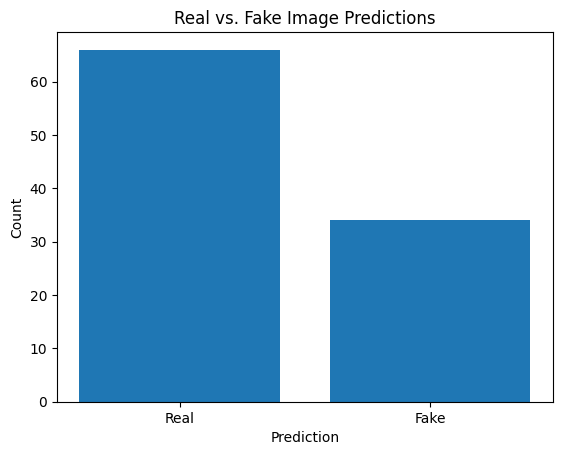

In [17]:
import os
import glob
import matplotlib.pyplot as plt

# Create a list of image file paths
image_dir = "/kaggle/input/thispersondoesnotexist/thispersondoesnotexist"
image_paths = glob.glob(os.path.join(image_dir, "*.png"))  # Change the file extension as needed

# Load the saved InceptionResNetV2 model
loaded_model = keras.models.load_model("/kaggle/input/datrgfff/inception_model.h5")

# Initialize counters for real and fake predictions
real_count = 0
fake_count = 0

# Predict each image and update the counters
for image_path in image_paths:
    result = predict_image_real_or_fake(image_path, loaded_model)
    if result == "Real":
        real_count += 1
    elif result == "Fake":
        fake_count += 1

# Create a bar chart to visualize the results
labels = ['Real', 'Fake']
counts = [real_count, fake_count]

plt.bar(labels, counts)
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.title('Real vs. Fake Image Predictions')
plt.show()
